In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

Using TensorFlow backend.


In [2]:
batch_size = 4
model_name = 'xception'
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [3]:
idg = ImageDataGenerator()
gen_test = idg.flow_from_directory('test', target_size=(height, width), shuffle=False, 
                                    class_mode=None, batch_size=batch_size)

Found 662 images belonging to 1 classes.


In [4]:
!ls models/irv2_0801*

models/irv2_0801-0.000100-100-0.934272.h5
models/irv2_0801-0.000100-51-0.943235.h5
models/irv2_0801-0.000100-52-0.945849.h5
models/irv2_0801-0.000100-53-0.947397.h5
models/irv2_0801-0.000100-54-0.948624.h5
models/irv2_0801-0.000100-55-0.947023.h5
models/irv2_0801-0.000100-56-0.951451.h5
models/irv2_0801-0.000100-57-0.952251.h5
models/irv2_0801-0.000100-58-0.941155.h5
models/irv2_0801-0.000100-59-0.944516.h5
models/irv2_0801-0.000100-60-0.954225.h5
models/irv2_0801-0.000100-61-0.951131.h5
models/irv2_0801-0.000100-62-0.950384.h5
models/irv2_0801-0.000100-63-0.946116.h5
models/irv2_0801-0.000100-64-0.944942.h5
models/irv2_0801-0.000100-65-0.951985.h5
models/irv2_0801-0.000100-66-0.946329.h5
models/irv2_0801-0.000100-67-0.952732.h5
models/irv2_0801-0.000100-68-0.950811.h5
models/irv2_0801-0.000100-69-0.944195.h5
models/irv2_0801-0.000100-70-0.946116.h5
models/irv2_0801-0.000100-71-0.949531.h5
models/irv2_0801-0.000100-72-0.942061.h5
models/irv2_0801-0.000100-73-0.943982.h5
models/irv2_080

In [5]:
base_model = MODEL(include_top=False, weights='imagenet')
input_tensor = Input((height, width, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
fname_model = 'models/irv2_0801-0.000100-60-0.954225.h5'
model.load_weights(fname_model)

In [7]:
model_parallel = multi_gpu_model(model, n_gpus)

In [8]:
y_pred = model_parallel.predict_generator(gen_test, verbose=1, workers=multiprocessing.cpu_count())

166/166 [==============================] - 95s 573ms/step


(array([421.,  15.,  13.,   6.,   5.,   7.,   8.,   7.,   9., 171.]),
 array([2.48491764e-04, 1.00223643e-01, 2.00198793e-01, 3.00173944e-01,
        4.00149095e-01, 5.00124246e-01, 6.00099397e-01, 7.00074548e-01,
        8.00049698e-01, 9.00024849e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

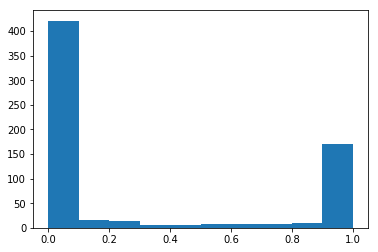

In [16]:
y_pred2 = 1 - y_pred[:,0]
plt.hist(y_pred2)

In [27]:
fname_model2 = fname_model[fname_model.rfind('/')+1:]
with open(f'pred_{fname_model2}.csv', 'w') as f:
    f.write('filename,probability\n')
    for fname, value in zip(gen_test.filenames, y_pred2):
        fname = fname[fname.rfind('/')+1:]
        if value == 1:
            value -= 1e-9
        f.write(f'{fname},{value:.9f}\n')